In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from saif.crs_model.peakdetector import pk_indxs
plt.style.use('ggplot')


### Load Data

In [2]:
SEISMIC_DATA = '/Users/pmh/Desktop/cushingSeismic.hdf5'
PRESSURE_DATA = '/Users/pmh/Desktop/cushingPressure.hdf5'

In [3]:
from orion_light import seismic_catalog
from orion_light import pressure_table

In [4]:
catalog = seismic_catalog.SeismicCatalog()
catalog.load_catalog_hdf5(SEISMIC_DATA)

In [5]:
pressure_model = pressure_table.PressureTableModel()
pressure_model.load_table(PRESSURE_DATA)

Loading pressure table from hdf5 file: /Users/pmh/Desktop/cushingPressure.hdf5


### Process $N(t)$

- Pressure data and seismic events are recorded at different times.
    - First goal: Clip all data to the time interval where we have samples for both pressure and seismic activity
    - Second goal: linearly interpolate the seismic data so that the event times align with the pressure data.
    - Third goal: empirically compute the rate (numerical derivative), in order to define R0.
- Partition the data into **main shock** and **interseismic** regions.
    - This should be done by a peak detector, but right now it is done manually (by visual inspection).

In [6]:
from scipy.interpolate import interp1d

Obtain the time intervals for the seismic data, and creating the interpolator.

In [7]:
Mc = 1.6
catalog.set_slice(magnitude_range = [Mc, 10])
magnitude=catalog.get_magnitude_slice()
event_times = catalog.get_epoch_slice() 
start_t = event_times[0]
end_t = event_times[-1]
event_times = event_times / 86400 / 365.25

t_n = event_times - event_times[0]
n_cnts = np.arange(len(t_n))
n_func1 = interp1d(t_n, n_cnts, kind='linear')
n_func2 = interp1d(t_n, magnitude, kind='nearest')

Obtain the time intervals for the pressure data, and interpolate the seismic data

In [8]:
t_p = pressure_epoch = pressure_model.table_data['t']
start_idx = np.where(t_p > start_t)[0][0]
end_idx = np.where(t_p > end_t)[0][0] - 1

t_p = t_p[start_idx:end_idx]
p = pressure_model.table_data['pressure'][1:][start_idx+1:end_idx]
dpdt = pressure_model.table_data['dpdt'][1:][start_idx+1:end_idx]

delta_t = t_p[1:] - t_p[:-1]

p = torch.FloatTensor(p)
dpdt = torch.FloatTensor(dpdt)
delta_t = torch.FloatTensor(delta_t)

t_p_interpolated = t_p / 86400 / 365.25 - event_times[0]
n_interpolated = n_func1(t_p_interpolated) # interpolated number of earthquakes 
magnitude_interpolated = n_func2(t_p_interpolated) # interpolated magnitude of earthquakes 

[   0 1370 1550 1970 2098 2523 3172 3668]


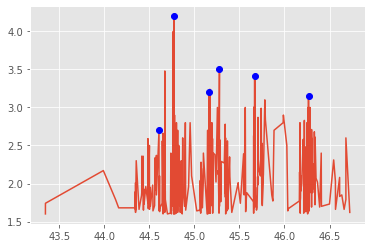

In [9]:
plt.plot(event_times, magnitude)
peak_indexs=pk_indxs(magnitude,trshd=0.3, min_dist=80)
plt.plot(event_times[peak_indexs],magnitude[peak_indexs],'o',color='b')
peak_indexs=(np.array((event_times[peak_indexs]-event_times[0])/t_p_interpolated[-1]*len(t_p_interpolated),dtype=int))
peak_indexs=np.insert(peak_indexs,0,0)
peak_indexs=np.insert(peak_indexs,np.size(peak_indexs),np.size(t_p_interpolated)-1)
print(peak_indexs)
empirical_rate = np.gradient(n_interpolated, t_p_interpolated)

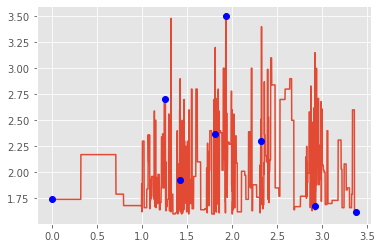

In [10]:
plt.plot(t_p_interpolated, magnitude_interpolated)
plt.plot(t_p_interpolated[peak_indexs],magnitude_interpolated[peak_indexs],'o',color='b')

[   0 1087 1162 1237 1371 1445 1550 1609 1972 2100 2192 2391 2521 3071
 3163 3251 3497 3668]
18


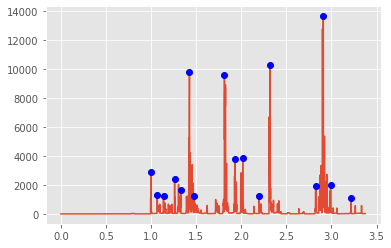

In [31]:
#empirical_rate = np.gradient(n_interpolated, t_p_interpolated)
#peak_indexs=pk_indxs(empirical_rate,trshd=0.08, min_dist=50)
#plt.plot(t_p_interpolated, empirical_rate)
#plt.plot(t_p_interpolated[peak_indexs],empirical_rate[peak_indexs],'o',color='b')
#peak_indexs=np.insert(peak_indexs,0,0)
#peak_indexs=np.insert(peak_indexs,np.size(peak_indexs),np.size(t_p_interpolated)-1)
#print(peak_indexs)
#print(np.size(peak_indexs))

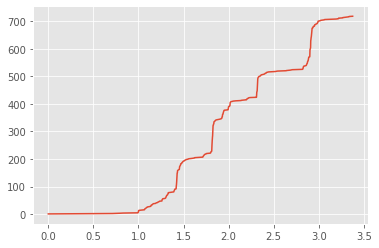

In [32]:
plt.plot(t_p_interpolated, n_interpolated)

Examining the first interseismic chunk (from t=0 years to t=1.3 years)

In [33]:
train_end = np.where(t_p_interpolated > 1.3)[0][0]

### Define site constants

### Sampling the grid

We keep the rate factor fixed, and examine the landscape for mu_minus_alpha and rate_coeff.

In [34]:
params = torch.FloatTensor([[0.5,1e-2,1e-4]])


# mu_minus_alpha_mesh = torch.linspace(0.1,1.0,101)
# rate_coeff_mesh = 10 ** torch.linspace(-4,-1,101)
# grid_mu, grid_rate = torch.meshgrid(mu_minus_alpha_mesh, rate_coeff_mesh, indexing='ij')

# params = torch.stack([
#     grid_mu.flatten(),
#     grid_rate.flatten(),
#     163.7424 / 1e6 * torch.ones_like(grid_rate.flatten()), # rate_factor 
# ]).T

# params.requires_grad_()



### Run Model

In [35]:
from model import CRSModel

In [36]:
Rt, Nt = model(params, p, dpdt, delta_t)

In [37]:
Rt

tensor([[3.1680e-05, 3.0733e-05, 2.9842e-05,  ..., 2.9649e-06, 2.9651e-06,
         2.9653e-06]])

In [38]:
Nt.shape

torch.Size([1, 3669])

Visualize a sample

Define the criterion: MSELoss.

- Be careful: we may need to normalize the data before using MSELoss.
- In future, we might forecast rate (or, $\Delta N(t)$) since this is easier to bound than total number.

In [39]:
#criterion = nn.MSELoss(reduction='sum')

In [40]:
#loss = criterion(Nt[:,1:], n_target[None,:])
#loss.item()

In [41]:
#loss.backward()

In [11]:
mpa_yr2pa_s = 1e6 / 365.25 / 86400
site_info = {
    'tectonic_shear_stressing_rate' : 3.5e-4 * mpa_yr2pa_s, # Pa / s
    'tectonic_normal_stressing_rate' : 0, # Pa/s
    'sigma' : 30 * 1e6, # Pa
    'biot' : 0.3, # dimensionless
    #'background_rate' : 1.36 / 365.25 / 86400, # event/second,
    'background_rate' : empirical_rate[0] / 365.25 / 86400, # event/second,
    'init_delta_t' : delta_t[0].item() }

In [12]:
from model import CRSModel
import torch.optim as optim
import torch.nn.functional as F
model = CRSModel(site_info)

params = torch.FloatTensor([[0.5,1e-2,0.0005]])
params.requires_grad=True
params.register_hook(lambda g: F.normalize(g))
optimizer = optim.SGD(params=[params],lr=0.000001,momentum=0.1)

criterion = nn.MSELoss(reduction='sum')
R0, N0 , n_target0 = torch.ones(1, 1),torch.ones(1, 1),torch.FloatTensor([])
for i in range(np.size(peak_indexs)-1):
   mpa_yr2pa_s = 1e6 / 365.25 / 86400
   site_info = {
    'tectonic_shear_stressing_rate' : 3.5e-4 * mpa_yr2pa_s, # Pa / s
    'tectonic_normal_stressing_rate' : 0, # Pa/s
    'sigma' : 30 * 1e6, # Pa
    'biot' : 0.3, # dimensionless
    #'background_rate' : 1.36 / 365.25 / 86400, # event/second,
    'background_rate' : empirical_rate[peak_indexs[i]+1] / 365.25 / 86400, # event/second,
    'init_delta_t' : delta_t[0].item() }
   model = CRSModel(site_info)
   p0 = torch.FloatTensor(p)[peak_indexs[i]+1:peak_indexs[i+1]]
   dpdt0 = torch.FloatTensor(dpdt)[peak_indexs[i]+1:peak_indexs[i+1]]
   delta_t0 = torch.FloatTensor(delta_t)[peak_indexs[i]+1:peak_indexs[i+1]]
   Rt, Nt = model(params, p0, dpdt0, delta_t0)
   R0=torch.cat((R0,Rt),dim=-1)
   #print(N0.detach()[0][-1])
   Nt=torch.add(Nt,N0.detach()[0][-1])
   #print(N0.detach())
   N0=torch.cat((N0,Nt),dim=-1)
   n_target= torch.FloatTensor(n_interpolated)[peak_indexs[i]:peak_indexs[i+1]]
   n_target0=torch.cat((n_target0,n_target),dim=-1)


In [ ]:
for epoch in range(500):
    R0, N0 , n_target0 = torch.ones(1, 1),torch.ones(1, 1),torch.FloatTensor([])
    for i in range(np.size(peak_indexs)-1):
             mpa_yr2pa_s = 1e6 / 365.25 / 86400
             site_info = {
                          'tectonic_shear_stressing_rate' : 3.5e-4 * mpa_yr2pa_s, # Pa / s
                          'tectonic_normal_stressing_rate' : 0, # Pa/s
                          'sigma' : 30 * 1e6, # Pa
                          'biot' : 0.3, # dimensionless
                          #'background_rate' : 1.36 / 365.25 / 86400, # event/second,
                          'background_rate' : empirical_rate[peak_indexs[i]+1] / 365.25 / 86400, # event/second,
                          'init_delta_t' : delta_t[0].item() }
             model = CRSModel(site_info)
             p0 = torch.FloatTensor(p)[peak_indexs[i]+1:peak_indexs[i+1]]
             dpdt0 = torch.FloatTensor(dpdt)[peak_indexs[i]+1:peak_indexs[i+1]]
             delta_t0 = torch.FloatTensor(delta_t)[peak_indexs[i]+1:peak_indexs[i+1]]
             
             Rt, Nt = model(params, p0, dpdt0, delta_t0)
             #print(empirical_rate[peak_indexs[i]],)
             R0=torch.cat((R0,Rt),dim=-1)
             #print(N0.detach()[0][-1])
             Nt=torch.add(Nt,N0.detach()[0][-1])
             #print(N0.detach())
             N0=torch.cat((N0,Nt),dim=-1)
             n_target= torch.FloatTensor(n_interpolated)[peak_indexs[i]:peak_indexs[i+1]]
             n_target0=torch.cat((n_target0,n_target),dim=-1)
             #print(n_target0.detach().size(),(N0[:,1:]).squeeze().detach().size())

    # loss = criterion(Nt[:,1:], n_target[None,:]) # Need to define a loss function that compares with the real data
    # Define a MSE of forecasted number Nt with the ground truth
    
    
    #print((N0[:,1:]).squeeze().detach().numpy(),n_target0.detach().numpy())
    loss = criterion((N0[:,1:]).squeeze(), n_target0)
    print('loss is ' + str(loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    Nt.shape

loss is 3002571776.0
loss is 2991641856.0
loss is 2979628800.0
loss is 2967516672.0
loss is 2955408384.0
loss is 2943310080.0
loss is 2931223040.0
loss is 2919145472.0
loss is 2907084800.0


tensor([[5.0000e-01, 9.9910e-03, 5.1348e-05]], requires_grad=True)


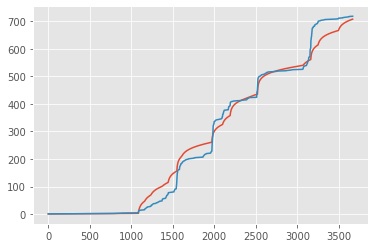

In [46]:
plt.plot((N0[:,1:]).squeeze().detach().numpy())
plt.plot(n_target0)
print(params)

In [ ]:
params = torch.FloatTensor([[5.0009e-01,2.7316e-03,3.0530e-04,5.0000e-04]])
Rt, Nt = model(params, p, dpdt, delta_t)
plt.plot(Nt.data.detach().numpy()[0])
plt.plot(n_target)
params = torch.FloatTensor([[5.0009e-01,2.7316e-03,163.7424,5.0000e-04]])
Rt, Nt = model(params, p, dpdt, delta_t)
plt.plot(Nt.data.detach().numpy()[0])

In [ ]:
print(Rt,Nt)